# Преобразование задачи в бинарную классификацию (определение вероятности принадлежности классу)

План: 
1. import
2. загрузка
  
  2.1 Описание классов

3. Подготовка обучающей и тестовой выборки
4. Machine learning

  4.1 Dense neural networks
  
  4.2.1 Desicion tree

  4.2.2 Random forest

  4.3 Bayes

5. Выводы

  


##1.import

In [ ]:
#Общие
import pandas as pd #работа с таблицами и
import numpy as np # работа с массивами
import matplotlib.pyplot as plt # визуализация
import seaborn as sns # визуализация
from datetime import datetime
%matplotlib inline

In [ ]:
sns.set_style('darkgrid')

In [ ]:
# Импорт библиотек для нейронных сетей
from sklearn.model_selection import train_test_split # разделение выборок на обучающую и тестовую
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils
from keras.utils.vis_utils import plot_model # визуализация архитектуры

In [ ]:
#Машинное обучение
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB, ComplementNB
from sklearn.model_selection import GridSearchCV # Итеративная подстановка парметров в модели
from sklearn import naive_bayes as nb
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, auc, f1_score, confusion_matrix,precision_score, recall_score, roc_auc_score, roc_curve

In [ ]:
# Подключаемся к Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Функции 


In [ ]:
# Функции метрик бинарной классификации
def value_of_metrics(y_true, y_pred):
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print('Recall: ', recall_score(y_true, y_pred))
    print('Precision: ', precision_score(y_true, y_pred))  
    print('F1: ', f1_score(y_true, y_pred))
    print('Roc_AUC: ', roc_auc_score(y_true, y_pred))
    print('Confusion Matrix: ')
    print(pd.DataFrame(confusion_matrix(y_true, y_pred)))
    
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.title('My DataSet')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
#Функция визуализации решающего дерева
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

##2.Загрузка данных

In [ ]:
# Выводим список файлов в папке
file_list = drive.ListFile({'q': "'1zW6RLEamxgNDJFb4ImVczgNZyeR8OCnc' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: fire_dataset_bin, id: 1bMf1YrIX_qaVOjK3YOV_1G1I9Q5OyKP7z9TicjeIR5k
title: fire_dataset, id: 1iaHaXbkH-zsZFutYzqCLSjLZV7RJRBF-PQomlt3YqDE
title: fire_dataset_bin.csv, id: 1ZtmgTYjDa0YeSSc5_0ZwG18tsGxT5bIQ
title: fire_dataset.csv, id: 1U6umxAw3lkFyKRAs2hfAzdirxziF7Plm
title: термоточки10_06_2020.csv, id: 16GYi82J4_sg0bnqHPjqMnXjlBLmegYEv
title: термоточки.csv, id: 1C19H0v2o97RL93CZJEGxsOMW07hR2f9v
title: 28900.11.06.2016.19.05.2020.1.0.0.ru.utf8.00000000.csv, id: 1lGnZLpVaSzpkE4SUh3LgbgjxISlkvCrQ
title: pogoda_samara.csv, id: 1M2QYaSUIbrAuaAC-wCuEMIkZ564vCUPg
title: samara_region.shx, id: 1ax48ucpaOvzbHhU-eBhBBZreTJxw84v6
title: samara_region.shp, id: 12oRmGW1zWEnuekJ09s6fw0N7_mYjLWgC
title: samara_region.dbf, id: 1m6nf4XEHHacRi3u8ByfZoFAoFCkfvc2V
title: samara_region.prj, id: 1tACrUjcDvKK_kw8Wm0ZJ4H7bINHRmAXL


In [ ]:
# получаем все файлы в списке
files = list()
def get_dict(lst):
  for file1 in file_list:
    files_dict = dict()
    files_dict['title'] = file1['title']
    files_dict['id'] = file1['id']
    lst.append(files_dict)
    print(files_dict)
    train_downloaded = drive.CreateFile({'id': file1['id']})
    train_downloaded.GetContentFile(file1['title'], 
                                    mimetype='application/vnd.openxmlformats-officedocument.spreadsheetml.sheet') # работает только если добавить это
  return

In [ ]:
# добавляем данные в память
get_dict(files)
!ls

{'title': 'fire_dataset_bin', 'id': '1bMf1YrIX_qaVOjK3YOV_1G1I9Q5OyKP7z9TicjeIR5k'}
{'title': 'fire_dataset', 'id': '1iaHaXbkH-zsZFutYzqCLSjLZV7RJRBF-PQomlt3YqDE'}
{'title': 'fire_dataset_bin.csv', 'id': '1ZtmgTYjDa0YeSSc5_0ZwG18tsGxT5bIQ'}
{'title': 'fire_dataset.csv', 'id': '1U6umxAw3lkFyKRAs2hfAzdirxziF7Plm'}
{'title': 'термоточки10_06_2020.csv', 'id': '16GYi82J4_sg0bnqHPjqMnXjlBLmegYEv'}
{'title': 'термоточки.csv', 'id': '1C19H0v2o97RL93CZJEGxsOMW07hR2f9v'}
{'title': '28900.11.06.2016.19.05.2020.1.0.0.ru.utf8.00000000.csv', 'id': '1lGnZLpVaSzpkE4SUh3LgbgjxISlkvCrQ'}
{'title': 'pogoda_samara.csv', 'id': '1M2QYaSUIbrAuaAC-wCuEMIkZ564vCUPg'}
{'title': 'samara_region.shx', 'id': '1ax48ucpaOvzbHhU-eBhBBZreTJxw84v6'}
{'title': 'samara_region.shp', 'id': '12oRmGW1zWEnuekJ09s6fw0N7_mYjLWgC'}
{'title': 'samara_region.dbf', 'id': '1m6nf4XEHHacRi3u8ByfZoFAoFCkfvc2V'}
{'title': 'samara_region.prj', 'id': '1tACrUjcDvKK_kw8Wm0ZJ4H7bINHRmAXL'}
28900.11.06.2016.19.05.2020.1.0.0.ru.utf8.00000000.cs

In [ ]:
# создаем dataframe
dataset_bin = pd.read_csv('fire_dataset_bin.csv', index_col=0)
dataset_bin.head()

area  lon  ...    VV   Td
2017-09-24 10:00:00   0.0  0.0  ...  10.0  4.3
2017-09-24 13:00:00   0.0  0.0  ...  10.0  3.1
2017-09-24 16:00:00   0.0  0.0  ...  10.0  2.3
2017-09-24 19:00:00   0.0  0.0  ...  10.0  1.2
2017-09-24 22:00:00   0.0  0.0  ...  10.0  2.3

[5 rows x 21 columns]

Удалим лишние колонки с координатами и расстоянием до дорог

In [ ]:
#удаляем лишние данные (100% корреляция с термоточкой)
dataset_bin = dataset_bin.drop(['lon', 'lat', 'Dist_str',	'Dist_railw',	'Dist_car'], axis = 1)
dataset_bin.head()

area     T  ...    VV   Td
2017-09-24 10:00:00   0.0   9.4  ...  10.0  4.3
2017-09-24 13:00:00   0.0  11.7  ...  10.0  3.1
2017-09-24 16:00:00   0.0  11.6  ...  10.0  2.3
2017-09-24 19:00:00   0.0   7.7  ...  10.0  1.2
2017-09-24 22:00:00   0.0   6.1  ...  10.0  2.3

[5 rows x 16 columns]

###2.1Описание классов

In [ ]:
# смотрим и считаем классы 
dataset_bin.area.value_counts()

0.0    7744
1.0     422
Name: area, dtype: int64

0 - нет термоточки

1 - термоточка (факт лесного пожара)

##3.Подготовка обучающей и тестовой выборки


In [ ]:
# работаем с категориальными данными
dataset_bin_gd = pd.get_dummies(dataset_bin) 
dataset_bin_gd.head(2)

area  ...  Cm_Высокослоистые просвечивающие.
2017-09-24 10:00:00   0.0  ...                                  0
2017-09-24 13:00:00   0.0  ...                                  0

[2 rows x 149 columns]

In [ ]:
# отделяем переменную y от вектора X
y = dataset_bin_gd['area'].astype('int')
X = dataset_bin_gd.drop(['area'], axis=1)

In [ ]:
X.shape

(8166, 148)

In [ ]:
y.head()

2017-09-24 10:00:00    0
2017-09-24 13:00:00    0
2017-09-24 16:00:00    0
2017-09-24 19:00:00    0
2017-09-24 22:00:00    0
Name: area, dtype: int64

Визуализация распределения классов

In [ ]:
mask_0 = dataset_bin_gd['area'] == 0
mask_1 = dataset_bin_gd['area'] == 1

In [ ]:
temp_0 = dataset_bin_gd[mask_0]
temp_1 = dataset_bin_gd[mask_1]

In [ ]:
temp_1.shape

(422, 149)

In [ ]:
temp_0.shape

(7744, 149)

In [ ]:
# sns.set_style("whitegrid");
# sns.pairplot(dataset_bin_gd, hue="area", size=3);
# plt.show()

Создаём обучающую и тестовую выборку


In [ ]:
# Разделение на обучающую (75%) и тестовую (25%) выборку 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

##4.Machine learning

Пробуем добавить сентетические данные, без перемешивания порядка записей, таким образом мы выровняем количество классов


In [ ]:
# объединяем X_train, y_train
XY = pd.concat([X_train, y_train], axis=1)
#расширяем датасет (мажоритарные данные)
area_0 = XY[XY.area==0]
area_1 = XY[XY.area==1]

area_upsampled = resample(area_1,
                          replace=True,
                          n_samples=len(area_0), 
                          random_state=42)


upsampled = pd.concat([area_0, area_upsampled])

print(upsampled.area.value_counts())

y_train_up = upsampled.area
X_train_up = upsampled.drop('area', axis=1)

1    5757
0    5757
Name: area, dtype: int64


###4.1 Dense neural networks

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               38144     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 128)               512       
_________________________________________________________________
dense_22 (Dense)             (None, 64)               

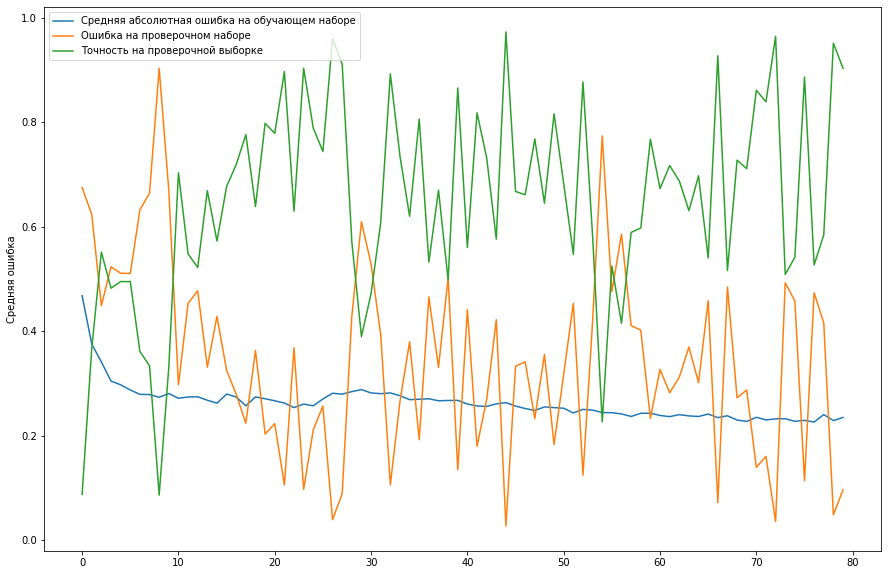

In [ ]:
# Лучшая полносвязная модель
model = Sequential()
# Входной полносвязный слой 
model.add(Dense(256, input_dim = X_train.shape[1], activation="relu"))
model.add(Dropout(0.22))
model.add(BatchNormalization())
# 1 скрытый слой
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.18))
model.add(BatchNormalization())
# 2 скрытый слой
model.add(Dense(64, activation= 'relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
# 3 скрытый слой
model.add(Dense(32, activation= 'relu'))
model.add(Dropout(0.2))
# Выходной полносвязный слой, (по количеству классов: 1 и 0)
model.add(Dense(1, activation="sigmoid"))

# Компиляция модели
model.compile(loss="mae", optimizer="adam", metrics=['accuracy'])


print(model.summary())
history = model.fit(X_train_up,
                    y_train_up, 
                    batch_size=400, 
                    epochs= 80,
                    validation_data=(X_test, y_test),
                    verbose=1)
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.plot(history.history['val_accuracy'], 
         label='Точность на проверочной выборке')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#обученная нейронная сеть
model_bin_dense = model.predict_classes(X_test)

In [ ]:
#смотрим количество классов в тестовой выборке
y_test.value_counts()

0    1987
1      55
Name: area, dtype: int64

In [ ]:
#смотрим предсказание нейронной сети
model_bin_dense_df = pd.DataFrame(model_bin_dense)
model_bin_dense_df[0].astype('int').value_counts()

0    1875
1     167
Name: 0, dtype: int64

In [ ]:
# создаем массив с предсказаниями модели, для построения confusion matrix
y_predicted = np.array(model_bin_dense_df[0].astype('int'))

Accuracy:  0.9030362389813908
Recall:  0.21818181818181817
Precision:  0.0718562874251497
F1:  0.10810810810810811
Roc_AUC:  0.5700873861920667
Confusion Matrix: 
      0    1
0  1832  155
1    43   12


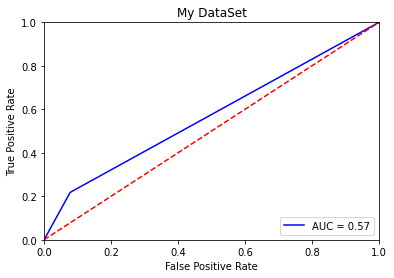

In [ ]:
value_of_metrics(y_test, model_bin_dense)

###4.2 Решающие деревья (decision tree)

###4.2.1 tree

In [ ]:
#создаём и обучаем классификатор
tree = DecisionTreeClassifier().fit(X_train, y_train)

In [ ]:
# делаем предсказание
tree_pred = tree.predict(X_test)

Accuracy:  0.9671890303623898
Recall:  0.14545454545454545
Precision:  0.2857142857142857
F1:  0.19277108433734938
Roc_AUC:  0.5676945600951641
Confusion Matrix: 
      0   1
0  1967  20
1    47   8


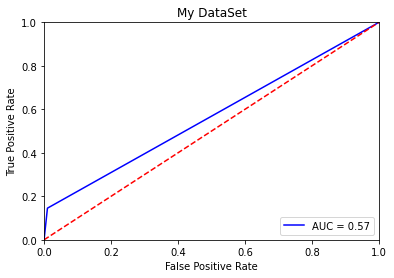

In [ ]:
#confusion matrix and ROC AUC
value_of_metrics(y_test, tree_pred)

In [ ]:
# Визуализируем работу классификатора
visualize_classifier(DecisionTreeClassifier(), np.array(X), np.array(y))

###4.2.2 Random forest

In [ ]:
#создаём и обучаем классификатор
model_RF = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
# делаем предсказание
model_RF_pred = model_RF.predict(X_test)

In [ ]:
# Смотрим предсказание классификатора
predictions_rf = pd.DataFrame(model_RF_pred)
predictions_rf[0].value_counts()

0    2041
1       1
Name: 0, dtype: int64

In [ ]:
#количество классов в тестовой выборке
y_test.value_counts()

0    1987
1      55
Name: area, dtype: int64

Accuracy:  0.9725759059745348
Recall:  0.0
Precision:  0.0
F1:  0.0
Roc_AUC:  0.49974836436839454
Confusion Matrix: 
      0  1
0  1986  1
1    55  0


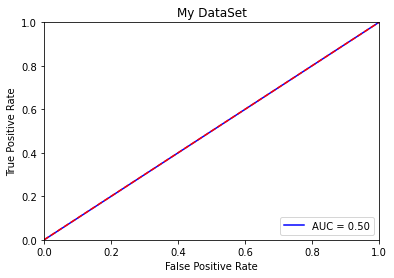

In [ ]:
#confusion matrix and ROC AUC
value_of_metrics(y_test, model_RF_pred)

Пробуем upsampling для random forest

Accuracy:  0.9730656219392753
Recall:  0.0
Precision:  0.0
F1:  0.0
Roc_AUC:  0.5
Confusion Matrix: 
      0  1
0  1987  0
1    55  0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


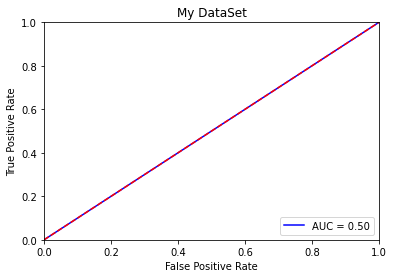

In [ ]:
#создаём классификатор RandomForestClassifier

model_RF_up = RandomForestClassifier().fit(X_train_up, y_train_up)
model_RF_up_pred = model_RF_up.predict(X_test)

#confusion matrix and ROC AUC
value_of_metrics(y_test, model_RF_up_pred)

###4.3 Байесовские классификаторы

In [ ]:
# Создаем классификаторы
#model1 = MultinomialNB() # нужен диапазон от 0 до 1
model2 = GaussianNB()
model3 = BernoulliNB()
#model4 = ComplementNB()
# model1.fit(X_train_up,y_train_up) # нужен диапазон от 0 до 1
model2.fit(X_train_up,y_train_up)
model3.fit(X_train_up,y_train_up)
#model4.fit(X_train_up,y_train_up)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
#y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)
#y_pred4 = model4.predict(X_test)

In [ ]:
y_test.value_counts()

0    1987
1      55
Name: area, dtype: int64

Accuracy:  0.17874632713026445
Recall:  0.9454545454545454
Precision:  0.030127462340672075
F1:  0.058394160583941604
Roc_AUC:  0.551489225419774
Confusion Matrix: 
     0     1
0  313  1674
1    3    52


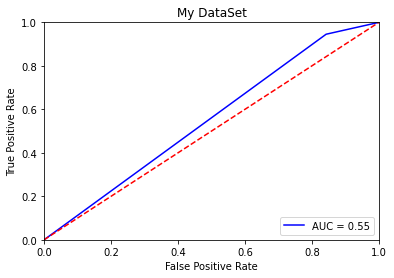

Accuracy:  0.7159647404505387
Recall:  0.7454545454545455
Precision:  0.06754530477759473
F1:  0.12386706948640483
Roc_AUC:  0.7303015052385964
Confusion Matrix: 
      0    1
0  1421  566
1    14   41


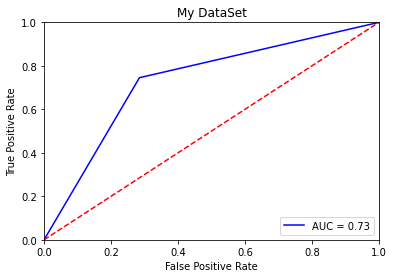

In [ ]:
#value_of_metrics(y_test, y_pred1)
value_of_metrics(y_test, y_pred2)
value_of_metrics(y_test, y_pred3)

In [ ]:
y_pred3[1000:2000]

###4.3.1 Доработка классификатора grid search

Т.к. Байесовский классификатор показал наилучший результат при определении классов, то имеет смысл доработать классификатор используя gridserach

Best params: 0.687679 using {'var_smoothing': 0.001} 

Accuracy:  0.6327130264446621
Recall:  0.5818181818181818
Precision:  0.04216073781291173
F1:  0.07862407862407862
Roc_AUC:  0.6079699867319394
Confusion Matrix: 
      0    1
0  1260  727
1    23   32


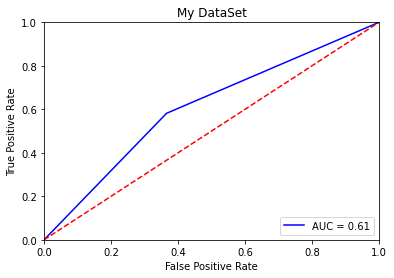

In [ ]:
# параметры сетки
grid = {
    'var_smoothing': [1e-09, 1e-10, 1e-11, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    }
#создаём и обчаем классификатор
gnb_model = GaussianNB()
gnb_model_gs = GridSearchCV(gnb_model, grid, refit = ['recall', 'precision', 'accuracy', 'F1'])
gnb_model_gs.fit(X_train_up, y_train_up)
# выводим лучшие параметры
print("Best params: %f using %s" % (gnb_model_gs.best_score_, gnb_model_gs.best_params_), '\n')
#проверяем точность классификатора
y_pred_gnb_gs = gnb_model_gs.predict(X_test)
value_of_metrics(y_test, y_pred_gnb_gs)

Best params: 0.705574 using {'alpha': 0.001, 'binarize': 0.0, 'fit_prior': 'True'} 

Accuracy:  0.718413320274241
Recall:  0.7454545454545455
Precision:  0.0681063122923588
F1:  0.12480974124809743
Roc_AUC:  0.7315596833966236
Confusion Matrix: 
      0    1
0  1426  561
1    14   41


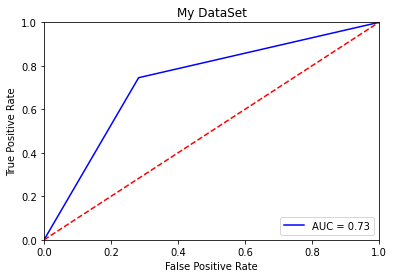

In [ ]:
# параметры сетки
grid = {
        'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 1.0],
        'binarize': [0.0, 0.2, 0.5],
        'fit_prior': ['True', 'False']
                 }

#создаём и обучаем классификатор
bnb_model = BernoulliNB()
bnb_model_gs = GridSearchCV(bnb_model, grid, refit = ['recall', 'precision', 'accuracy', 'F1'])
bnb_model_gs.fit(X_train_up, y_train_up)

# выводим лучшие параметры
print("Best params: %f using %s" % (bnb_model_gs.best_score_, bnb_model_gs.best_params_), '\n')

# проверяем точность классификатора
y_pred_bnb_gs = bnb_model_gs.predict(X_test)
value_of_metrics(y_test, y_pred_bnb_gs)

In [ ]:
# создадим классификатор, который на выходе выдаёт вероятность
y_pred_bnb_gs_p = bnb_model_gs.predict_proba(X_test)


In [ ]:
# создаем два пустых списка с цветами и со значениями класса термоточки 
color_list = []
val_list = []
# присваиваем цвета верояностям, в зависимости от величины значения
for i in y_pred_bnb_gs_p:
  if i[1] <= 0.33:
    color_list.append('g')
  elif 0.33 < i[1] <= 0.73:
    color_list.append('y')
  else:
    color_list.append('r')
  val_list.append(round(i[1], 2)*100)

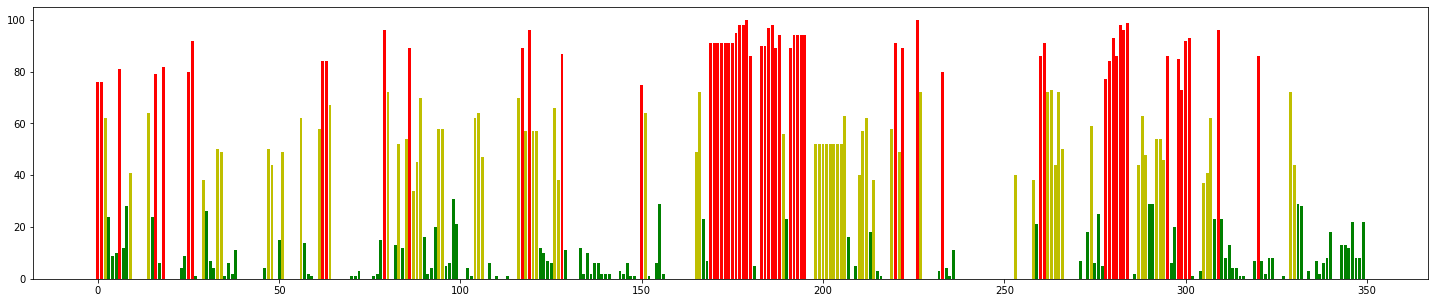

In [ ]:
# создаём график со значением вероятности и цветом
# values of x 
x = np.array(range(len(val_list))) 
# values of y 
y = np.array(val_list) 

fig = plt.figure(figsize=(25,5))
for i in range(350):#len(x)): 
      
    # plotting the corresponding x with y  
    # and respective color 
    plt.bar(x[i], y[i], color=color_list[i])

plt.show()

    #plt.scatter(x[i], y[i], c = color_list[i], linewidth = 2) 
#plt.show()

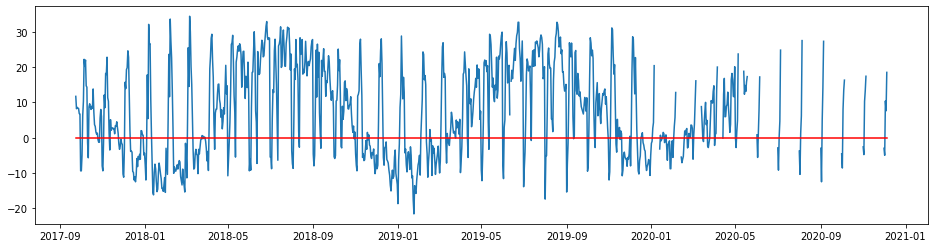

In [ ]:
X.index = pd.to_datetime(X.index)

plt.figure(figsize=(16,4))
plt.plot(X['T'].loc[X.index.hour == 13].resample('D').mean()) # минусы летом???
plt.plot([X.index[0], X.index[-1]], [0, 0], color='r')

# 5.Сравнение с теоретическим рассчетом

Будем сравнивать предсказанную пожароопасность с рассчетом по формуле Нестерова.

In [ ]:
comp = pd.DataFrame(X_test[['T', 'Td']], index=X_test.index) # необходимая информация
comp['predict_prob'] = y
comp.index = pd.to_datetime(comp.index)

In [ ]:
# загружаем данные о погоде
pogoda_samara_df = pd.read_csv('pogoda_samara.csv', sep = ';', skiprows=6)
# выравниваем названия колонок
pogoda_samara_df.columns = ['T', 'Po', 'P', 'Pa', 'U', 'DD', 'Ff', 'ff10', 'ff3', 
                            'N', 'WW', 'W1', 'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm', 
                            'Ch', 'VV', 'Td', 'RRR', 'tR', 'E', 'Tg', "E'", 'sss', 'sss2']
pogoda_samara_df.index = pd.to_datetime(pogoda_samara_df.index)
pogoda_samara_df = pogoda_samara_df.sort_index(ascending=True)
pogoda_samara_df = pogoda_samara_df[X_test.index.min():X_test.index.max()] # Оставим только данные для теста
pogoda_samara_df['RRR'].replace({'Осадков нет':0, 'Следы осадков':0.05}, inplace=True) # Заменяем категориальные признаки
pogoda_samara_df.head(3)

T     Po      P   Pa  ...   Tg   E'  sss  sss2
2019-09-14 04:00:00  10.5  752.8  765.4 -0.6  ...  NaN  NaN  NaN   NaN
2019-09-14 07:00:00  10.7  752.2  764.9 -0.6  ...  7.0  NaN  NaN   NaN
2019-09-14 10:00:00  19.2  751.6  763.9 -0.6  ...  NaN  NaN  NaN   NaN

[3 rows x 29 columns]

In [ ]:
pogoda_samara_df['RRR'].isna().sum()/len(pogoda_samara_df['RRR']) # оченб мало данных по кол-ву осадков

0.7513839959738299

In [ ]:
comp = pd.merge(comp, pogoda_samara_df['RRR'], left_index=True, right_index=True) # собираем в один сет
comp.fillna(0, inplace=True) # скорее всего
comp['RRR'] = comp['RRR'].apply(float)

In [ ]:
# У нас данные часовые, для расчет нужны дневные
comp_per_day = pd.DataFrame([
    comp['RRR'].resample('D').sum(),
    comp['T'].loc[comp.index.hour == 13].resample('D').mean(),
    comp['Td'].loc[comp.index.hour == 13].resample('D').mean(),
    comp['predict_prob'].resample('D').max()], # max()/mean()??
).T

comp_per_day.dropna(inplace=True)

In [ ]:
nesterov = np.array((comp_per_day['T']-comp_per_day['Td'])*comp_per_day['T']) #показатель Нестерова
nesterov_sum = np.zeros(comp_per_day.shape[0])
nesterov_sum[0] = nesterov[0]

#показатель Нестерова аккумулируется по дням
for i in range(len(nesterov_sum)-1):
  if comp_per_day['RRR'].iloc[i+1]<=0.1:
    nesterov_sum[i+1] = nesterov_sum[i]+nesterov[i+1]
  elif (comp_per_day['RRR'].iloc[i+1]>0.1) & (comp_per_day['RRR'].iloc[i+1]<=0.9):
    nesterov_sum[i+1] = nesterov_sum[i]*0.8 + nesterov[i+1]
  elif (comp_per_day['RRR'].iloc[i+1]>0.9) & (comp_per_day['RRR'].iloc[i+1]<=2):
    nesterov_sum[i+1] = nesterov_sum[i]*0.6 + nesterov[i+1]
  elif (comp_per_day['RRR'].iloc[i+1]>2) & (comp_per_day['RRR'].iloc[i+1]<=5):
    nesterov_sum[i+1] = nesterov_sum[i]*0.4 + nesterov[i+1]
  elif (comp_per_day['RRR'].iloc[i+1]>5) & (comp_per_day['RRR'].iloc[i+1]<=14):
    nesterov_sum[i+1] = nesterov_sum[i]*0.2 + nesterov[i+1]
  elif (comp_per_day['RRR'].iloc[i+1]>14) & (comp_per_day['RRR'].iloc[i+1]<=19):
    nesterov_sum[i+1] = nesterov_sum[i]*0.1 + nesterov[i+1]
  else:
    nesterov_sum[i+1]=0
  
  if (comp_per_day.iloc[i+1]['T']<0):
    nesterov_sum[i+1] = 0

comp_per_day['nesterov'] = nesterov_sum

In [ ]:
comp_per_day

RRR     T    Td  predict_prob   nesterov
2019-09-14  0.00  24.7   5.8          81.0  466.83000
2019-09-15  5.00  13.3  10.6          64.0  222.64200
2019-09-16  2.00  12.3   6.3          82.0  207.38520
2019-09-17  0.05  18.2   6.2          92.0  425.78520
2019-09-18  0.30  16.3   2.0          50.0  573.71816
...          ...   ...   ...           ...        ...
2020-12-01  0.10  -3.0  -3.5          25.0    0.00000
2020-12-02  0.00  -5.0 -10.3          63.0    0.00000
2020-12-03  2.00  10.4   5.0          64.0   56.16000
2020-12-04  2.00   7.6   2.3          99.0   73.97600
2020-12-05  0.05  18.5   4.1          81.0  340.37600

[248 rows x 5 columns]

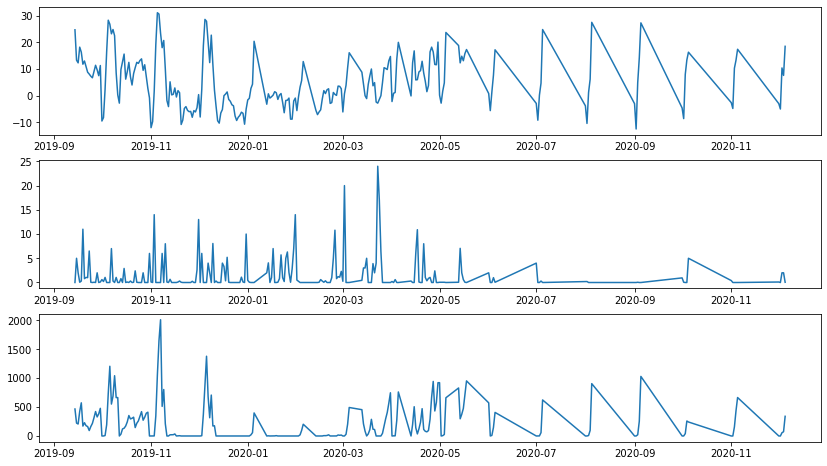

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(311)
plt.plot(comp_per_day['T'])
plt.subplot(312)
plt.plot(comp_per_day['RRR'])
plt.subplot(313)
plt.plot(comp_per_day['nesterov'])

In [ ]:
comp_per_day['2020-06-01':'2020-09-01'] # минус летом???? Очень мало данных здесь

RRR     T    Td  predict_prob    nesterov  nesterov_cat
2020-06-01  2.00   0.8  -1.3        31.000  573.536016             0
2020-06-02  0.00  -5.6 -10.5        56.625    0.000000             0
2020-06-03  0.00   1.4  -5.4        71.875    9.520000             0
2020-06-04  1.00   7.7 -10.8        35.500  148.162000             0
2020-06-05  0.05  17.2   2.1        11.875  407.882000             0
2020-07-01  4.00  -2.9  -3.6         2.125    0.000000             0
2020-07-02  0.00  -9.2 -12.6        35.375    0.000000             0
2020-07-03  0.00   0.2  -7.4        53.375    1.520000             0
2020-07-04  0.30   4.7  -7.4        27.000   58.086000             0
2020-07-05  0.00  24.8   2.0        19.125  623.526000             1
2020-08-01  0.20  -3.8  -5.2         7.375    0.000000             0
2020-08-02  0.20 -10.4 -13.1        38.250    0.000000             0
2020-08-03  0.00   1.2  -5.5        45.875    8.040000             0
2020-08-04  0.00   6.2  -8.2        26.625   97.320000             0
2020-08-05  0.00  27.5  -1.9        67.750  905.820000             0
2020-09-01  0.00  -3.0  -4.2         0.875    0.000000             0

In [ ]:
def fire_cat(data):
  if data<=300: # опасность отсутствует
    return 0
  elif (data>300) & (data<=1000): # малая
    return 1
  elif (data>1000) & (data<=4000): # средняя
    return 2
  elif (data>4000) & (data<=10000): # высокая
    return 3
  elif (data>10000): # чрезвычайная
    return 4

comp_per_day['nesterov_cat'] = comp_per_day['nesterov'].apply(fire_cat)

In [ ]:
def fire_cat_pred(data):
  if data<=20: # опасность отсутствует
    return 0
  elif (data>20) & (data<=40): # малая
    return 1
  elif (data>40) & (data<=60): # средняя
    return 2
  elif (data>60) & (data<=80): # высокая
    return 3
  elif (data>80): # чрезвычайная
    return 4

comp_per_day['predict_cat'] = comp_per_day['predict_prob'].apply(fire_cat_pred)

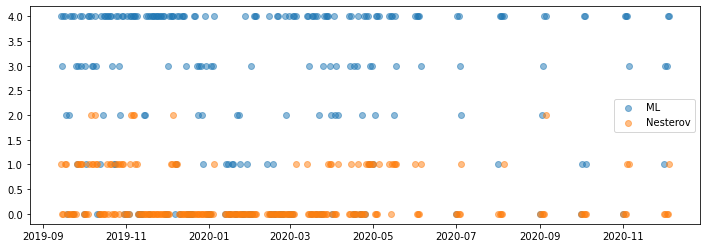

In [ ]:
plt.figure(figsize=(12,4))
plt.scatter(comp_per_day.index, comp_per_day['predict_cat'], alpha=0.5, label='ML')
plt.scatter(comp_per_day.index, comp_per_day['nesterov_cat'], alpha=0.5, label='Nesterov')
plt.legend(loc=0)